In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
from math import isnan

# Visualization plots
from matplotlib import pyplot as plt
import seaborn as sns

# ML Data Preparation
from sklearn.preprocessing import LabelEncoder # labeling of categorical target variables
from sklearn.preprocessing import StandardScaler # scale values to standard normal distribution X~N(0,1)
from sklearn.model_selection import train_test_split # train-test data split

# ML Feature Importance Analysis
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# ML Techniques
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ML Model Evaluation
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Support Vector Machine
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

### Special Requirement - merge the replacement values from the auxiliary file (as specified in the project description)

In [29]:
df = pd.read_csv('train.csv')
df_replace = pd.read_csv('train_updates_20220929.csv')
df = df.drop('data_source', axis=1)
df_replace = df_replace.drop('data_source', axis=1)

df = df.merge(df_replace, on='seq_id', how='left')
df = df.loc[:,~df.columns.str.match(r'(.*?)\_y')]

In [30]:
df = df.rename(columns=lambda x: re.sub(r'\_x', '', x))

In [31]:
df.head()

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


# 1. Data Preparation

## 1.1 Create new columns/features

In [5]:
df_n = df.groupby('protein_sequence').agg({'tm': 'max','pH': 'mean'})
df_n = pd.DataFrame(df_n).reset_index()
df_n

,protein_sequence,tm,pH
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,75.7,7.0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,50.5,7.0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,40.5,7.0
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,47.2,7.0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,49.5,7.0
...,...,...,...
28976,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,51.8,7.0
28977,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,37.2,7.0
28978,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,64.6,7.0
28979,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,50.7,7.0


In [6]:
df_n['First_3_AA'] = df_n['protein_sequence'].apply(lambda x:x[0:3])
df_n['Seq_Len'] = df_n['protein_sequence'].apply(lambda x:len(x))

## 1.2 Analysis

In [7]:
df_rpt = df.groupby(['First_3_AA'])['tm'].mean()
df_rpt = pd.DataFrame(df_rpt).sort_values(by='tm',ascending=False)
df_rpt

,tm
First_3_AA,
SHT,98.400000
MWW,98.200000
NPK,96.100000
GTG,95.200000
AYL,95.100000
...,...
MIS,29.539744
ADL,29.400000
NQA,25.000000


In [ ]:
df = df.sort_values(by='tm',ascending=False).reset_index(drop=True)

In [ ]:
import re


def find_ngrams(text: str, number: int=3) -> set:
    """
    returns a set of ngrams for the given string
    :param text: the string to find ngrams for
    :param number: the length the ngrams should be. defaults to 3 (trigrams)
    :return: set of ngram strings
    """

    if not text:
        return set()

    words = [f'  {x} ' for x in re.split(r'\W+', text.lower()) if x.strip()]

    ngrams = set()

    for word in words:
        for x in range(0, len(word) - number + 1):
            ngrams.add(word[x:x+number])

    return ngrams


def similarity(text1: str, text2: str, number: int=3) -> float:
    """
    Finds the similarity between 2 strings using ngrams.
    0 being completely different strings, and 1 being equal strings
    """

    ngrams1 = find_ngrams(text1, number)
    ngrams2 = find_ngrams(text2, number)

    num_unique = len(ngrams1 | ngrams2)
    num_equal = len(ngrams1 & ngrams2)

    return float(num_equal) / float(num_unique)

In [ ]:
find_similarity(df['protein_sequence'])

# 2. Analyze the PDB file

This section is authored by Kaggle Master - MARÍLIA PRATA.

https://www.kaggle.com/code/mpwolke/novozymes-pdb-file

## 2.1 Install Biopandas and import the libraries

In [8]:
# !pip install biopandas # install package only once

     |████████████████████████████████| 878 kB 7.6 MB/s eta 0:00:01


In [9]:
# Code by Moth https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/354339

from biopandas.pdb import PandasPdb

pdb_df =  PandasPdb().read_pdb('wildtype_structure_prediction_af2.pdb')
print(pdb_df.df.keys())

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])


In [10]:
#Code by Moth https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/354339

atom_df = pdb_df.df['ATOM']
hetatm_df = pdb_df.df['HETATM']
anisou_df = pdb_df.df['ANISOU']
others_df = pdb_df.df['OTHERS']

In [11]:
hetatm_df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx


In [12]:
anisou_df.tail()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,"U(1,1)","U(2,2)","U(3,3)","U(1,2)","U(1,3)","U(2,3)",blank_4,element_symbol,charge,line_idx


In [13]:
others_df.head()

,record_name,entry,line_idx
0,TER,3318 LYS A 221,3317
1,END,,3318


In [51]:
atom_df

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,ATOM,3313,,NZ,,LYS,,A,221,,,4.616,13.323,-4.301,1.0,93.80,,,N,NaN,3312
3313,ATOM,3314,,HZ1,,LYS,,A,221,,,5.270,12.565,-4.432,1.0,93.80,,,H,NaN,3313
3314,ATOM,3315,,HZ2,,LYS,,A,221,,,4.585,13.517,-3.310,1.0,93.80,,,H,NaN,3314
3315,ATOM,3316,,HZ3,,LYS,,A,221,,,4.965,14.143,-4.776,1.0,93.80,,,H,NaN,3315


## 2.2 Visualize the b_factor

The B-factor describes the displacement of the atomic positions from an average (mean) value (mean-square displacement).

The core of the molecule usually has low B-factors, due to tight packing of the side chains (enzyme active sites are usually located there). The values of the B-factors are normally between 15 to 30 (sq. Angstroms), but often much higher than 30 for flexible regions.

Code by Sowmyalr  https://www.kaggle.com/code/lrsowmya/biopandas-for-analysing-pdb-files

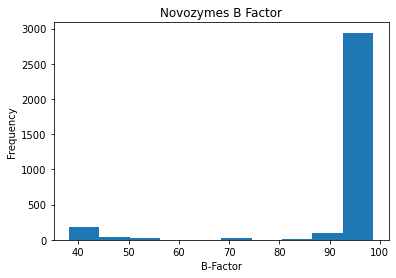

In [15]:
# Code by Sowmyalr  https://www.kaggle.com/code/lrsowmya/biopandas-for-analysing-pdb-files

atom_df['b_factor'].plot(kind='hist')
plt.title('Novozymes B Factor')
plt.xlabel('B-Factor');

### Insights from the above findings

It is observed that Novozymes has high B factor which means it is not tightly packed.

In [16]:
# Code by Sowmyalr  https://www.kaggle.com/code/lrsowmya/biopandas-for-analysing-pdb-files

atom_df.element_symbol.unique()

array(['N', 'H', 'C', 'O', 'S'], dtype=object)

### Debye-Waller Factor. The B-Factor Definition

"The temperature factor (also called the temperature value, B factor, B value, or Debye-Waller factor) is"

"A factor that can be applied to the X-ray scattering term for each atom (or for groups of atoms) that describes the degree to which the electron density is spread out. While the theory is that the B-factor indicates the true static or dynamic mobility of an atom, it can also indicate where there are errors in model building."

The B-factor is given by

$B_i = 8π^2U_i^2$

"Where $U_i^2$ is the mean square displacement of atom i. As U increases, the B-factor increases and the contribution of the atom to the scattering is decreased. If atoms are incorrectly positioned in the model, their B-factors will tend to be higher than correctly positioned atoms nearby[3]. For a B-factor of 15 $Å^2$, the mean square displacement of an atom from its equilibrium position is approximately 0.44 Å, and approximately 0.87 Å for a B-factor of 60 $Å^2$. For comparison, the van der Waals diameter of a carbon atom is 3.4 Å".

https://proteopedia.org/wiki/index.php/Temperature

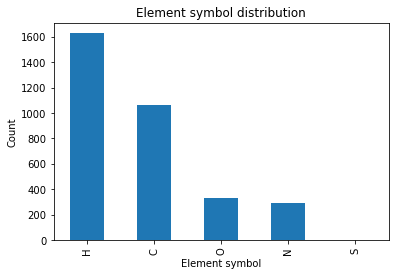

In [17]:
# Code by Sowmyalr  https://www.kaggle.com/code/lrsowmya/biopandas-for-analysing-pdb-files

atom_df['element_symbol'].value_counts().plot(kind='bar')
plt.title('Element symbol distribution')
plt.ylabel('Count')
plt.xlabel('Element symbol');

#Temperature Value/Factor and PDB file format

"The temperature value is recorded in the atomic coordinate file. In the PDB file format, it is the last numeric value (columns 61-66) in each ATOM and HETATM record. Coloring by temperature is a common way to visualize the uncertainty for each atom."

"PDB files for models determined by cryo-EM often specify values in the temperature/B factor field. However, a 2017 analysis concluded that "the treatment of the atomic displacement (B) factors was meaningless in almost all analyzed cryo-EM models".

https://proteopedia.org/wiki/index.php/Temperature

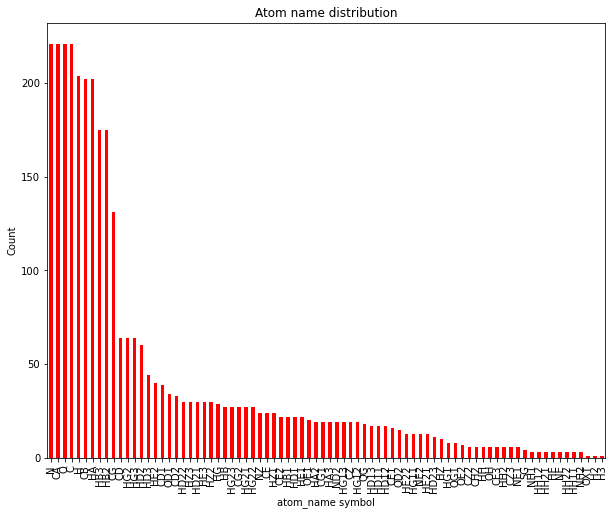

In [18]:
#Code by Sowmyalr  https://www.kaggle.com/code/lrsowmya/biopandas-for-analysing-pdb-files

atom_df['atom_name'].value_counts().plot(kind='bar', figsize=(10,8), color='r')
plt.title('Atom name distribution')
plt.ylabel('Count')
plt.xlabel('atom_name symbol');

### Utility of B-Factors in Protein Science

Utility of B-Factors in Protein Science: Interpreting Rigidity, Flexibility, and Internal Motion and Engineering Thermostability

Authors: Zhoutong Sun , Qian Liu , Ge Qu , Yan Feng , Manfred T Reetz - Chem Rev
. 2019 Feb 13;119(3):1626-1665. doi: 10.1021/acs.chemrev.8b00290.

"The term B-factor, sometimes called the Debye-Waller factor, temperature factor, or atomic displacement parameter, is used in protein crystallography to describe the attenuation of X-ray or neutron scattering caused by thermal motion."

"That review begins with analyses of early protein studies which suggested that B-factors, available from the Protein Data Bank, can be used to identify the flexibility of atoms, side chains, or even whole regions. This requires a technique for obtaining normalized B-factors."

"Since then the exploitation of B-factors has been extensively elaborated and applied in a variety of studies with quite different goals, all having in common the identification and interpretation of rigidity, flexibility, and/or internal motion which are crucial in enzymes and in proteins in general. Importantly, that review includes a discussion of limitations and possible pitfalls when using B-factors."

" A second research area, which likewise exploits B-factors, is also reviewed, namely, the development of the so-called B-FIT ('B-factor iterative test') directed evolution method for increasing the thermostability of enzymes as catalysts in organic chemistry and biotechnology."

"In both research areas, a maximum of structural and mechanistic insights is gained when B-factor analyses are combined with other experimental and computational techniques."

https://pubmed.ncbi.nlm.nih.gov/30698416/

In [19]:
ppdb_df =  PandasPdb().read_pdb('wildtype_structure_prediction_af2.pdb')

In [20]:
catom_df = ppdb_df.df['ATOM']
chtm_df = ppdb_df.df['HETATM']

In [21]:
catom_df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,...,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,...,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,...,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,...,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,...,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4


### Protein Thermostability. B-FIT Method.

Enhancement of protein thermostability by three consecutive mutations using loop-walking method and machine learning

Citation: Yoshida, K., Kawai, S., Fujitani, M. et al. Enhancement of protein thermostability by three consecutive mutations using loop-walking method and machine learning. Sci Rep 11, 11883 (2021). https://doi.org/10.1038/s41598-021-91339-4

"The authors developed a method to improve protein thermostability, “loop-walking method”. Three consecutive positions in 12 loops of Burkholderia cepacia lipase were subjected to random mutagenesis to make 12 libraries. Screening allowed us to identify L7 as a hot-spot loop having an impact on thermostability, and the P233G/L234E/V235M mutant was found from 214 variants in the L7 library."

TEMPERATURE, pH, SOLVENT and LOOP STRUCTURES

" Loop structures are susceptible to temperature, pH, and solvent, and frequently show high B-factors; the B factor is a crystallographic temperature factor, which can be used as an index for predicting destabilization sites. B-FIT is a method that combines the B-factor with directed evolution, and the thermostability of Bacillus subtilis lipase has been improved."

"Thermostability and optimum temperature"

"The thermostability of mutants was evaluated by comparing the residual activity of the samples that were heat-treated at each temperature (from 40 to 70 °C) for 30 min. The optimum temperature was evaluated by comparing the hydrolytic activity of the sample at each temperature (from 40 to 70 °C). "

https://www.nature.com/articles/s41598-021-91339-4

## Visualizations with Biokit

In [22]:
# !pip install biokit # install package only once

     |████████████████████████████████| 162 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 9.0 MB/s eta 0:00:01
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     |████████████████████████████████| 47 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 144 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 5.2 MB/s eta 0:00:011


  Created wheel for biokit: filename=biokit-0.5.0-py3-none-any.whl size=177133 sha256=4f590fb8243fec748d3471b9d9da451c74fd7545186fdfaa4203b5db4ded1c87
  Stored in directory: /Users/amosfang/Library/Caches/pip/wheels/e1/45/cd/b9a99738f30bb8dc3cebb9edecc0b47c784ac4020c91f62c95
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64216 sha256=7a245a45087df74bcd4dbe352cc822e6e613fa0ffa56881d7702ca9e96ed1d10
  Stored in directory: /Users/amosfang/Library/Caches/pip/wheels/e2/47/9f/de01f291cfde341b33383bcf1292b17d64c700d4a12b318a7d
  Created wheel for bioservices: filename=bioservices-1.10.4-py3-none-any.whl size=230571 sha256=43b5fbca31e2410568134a782bbe63b5f05e170ab1b2eb44b5d8f9f1142b5019
  Stored in directory: /Users/amosfang/Library/Caches/pip/wheels/c6/0e/cd/c43122ec1b7a34d6ae165695f4520ae18d58cac45b75e197a8
  Created wheel for colormap: filename=colormap-1.0.4-py3-none-any.whl size=15617 sha256=3fe19fb1e9af0e4581ac6ca3a79478fed2f6d84c18e75c8f154c7d7c31aba60e
  Sto

## Biokit Generic statistical tools

Automatic Adaptative Mixture Fitting

Creating directory /Users/amosfang/Library/Application Support/biokit 
Creating directory /Users/amosfang/Library/Application Support/bioservices 


/Users/amosfang/opt/anaconda3/lib/python3.8/site-packages/biokit/stats/mixture.py:196: RuntimeWarning: divide by zero encountered in log
  res = -1 * pylab.log(self.pdf(sample, params)).sum()


Found min  2344.3323823659584 for k   2
Found min  2344.3323823659584 for k   2


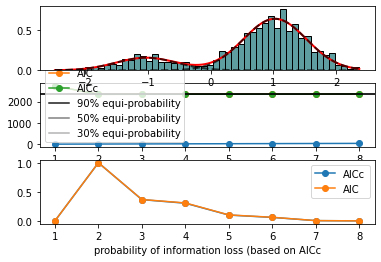

In [23]:
#Code by https://biokit.readthedocs.io/en/latest/references.html#biokit.viz.hist2d.Hist2D

from biokit.stats.mixture import AdaptativeMixtureFitting, GaussianMixture
m = GaussianMixture(mu=[-1,1], sigma=[0.5,0.5], mixture=[0.2,0.8])
amf = AdaptativeMixtureFitting(m.data)
amf.run(kmin=1, kmax=6)
amf.diagnostic(k=amf.best_k);

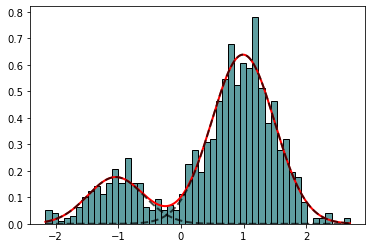

In [24]:
#Code by https://biokit.readthedocs.io/en/latest/references.html#biokit.viz.hist2d.Hist2D

from biokit.stats.mixture import GaussianMixture, EM
m = GaussianMixture(mu=[-1,1], sigma=[0.5,0.5], mixture=[0.2,0.8])
em = EM(m.data)
em.estimate(k=2)
em.plot()

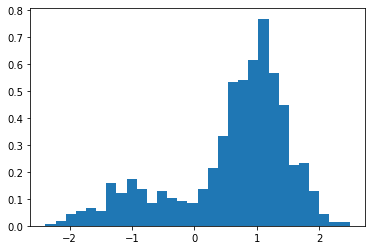

In [25]:
#Code by https://biokit.readthedocs.io/en/latest/references.html#biokit.viz.hist2d.Hist2D

from biokit.stats.mixture import GaussianMixture
m = GaussianMixture(mu=[-1,1], sigma=[0.5, 0.5], mixture=[.2, .8], N=1000)
m.plot()

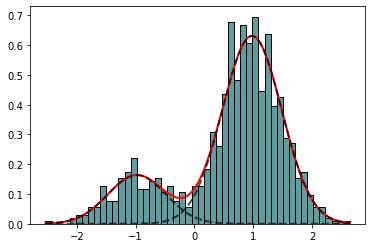

In [26]:
#Code by https://biokit.readthedocs.io/en/latest/references.html#biokit.viz.hist2d.Hist2D

from biokit.stats.mixture import GaussianMixture, GaussianMixtureFitting
m = GaussianMixture(mu=[-1,1], sigma=[0.5,0.5], mixture=[0.2,0.8])
mf = GaussianMixtureFitting(m.data)
mf.estimate(k=2)
mf.plot()

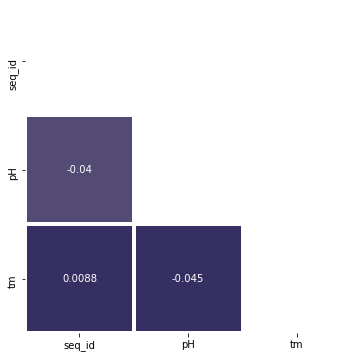

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors

#Code by SHI LONG ZHUANG  https://www.kaggle.com/code/shilongzhuang/intro-to-mice-an-imputation-strategy


f4 = df[['seq_id', 'protein_sequence', 'pH', 'tm', ]]


plt.subplots(figsize = (6, 6))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ['#363062',
                                                            '#E9D5CA',
                                                            '#363062',
                                                           ])

mask = np.triu(np.ones_like(f4.corr() ))
sns.heatmap(f4.corr(),
            mask = mask,
            cmap = cmap,
            cbar = False,
            square = True,
            annot = True,
            linewidths = 3,
           );

## Trying another Script

Import Packages and Helper Functions

In [34]:
from Bio.PDB import PDBParser
import sys
import Bio.PDB
import Bio.PDB.StructureBuilder
from Bio.PDB.Residue import Residue

In [35]:
#Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

class SloppyStructureBuilder(Bio.PDB.StructureBuilder.StructureBuilder):
    """Cope with resSeq < 10,000 limitation by just incrementing internally.

    # Q: What's wrong here??
    #   Some atoms or residues will be missing in the data structure.
    #   WARNING: Residue (' ', 8954, ' ') redefined at line 74803.
    #   PDBConstructionException: Blank altlocs in duplicate residue SOL
    #   (' ', 8954, ' ') at line 74803.
    #
    # A: resSeq only goes to 9999 --> goes back to 0 (PDB format is not really
    #    good here)
    """

    # NOTE/TODO:
    # - H and W records are probably not handled yet (don't have examples
    #   to test)

    def __init__(self, verbose=False):
        Bio.PDB.StructureBuilder.StructureBuilder.__init__(self)
        self.max_resseq = -1
        self.verbose = verbose

    def init_residue(self, resname, field, resseq, icode):
        """Initiate a new Residue object.

        Arguments:
        o resname - string, e.g. "ASN"
        o field - hetero flag, "W" for waters, "H" for
            hetero residues, otherwise blanc.
        o resseq - int, sequence identifier
        o icode - string, insertion code

        """
        if field != " ":
            if field == "H":
                # The hetero field consists of
                # H_ + the residue name (e.g. H_FUC)
                field = "H_" + resname
        res_id = (field, resseq, icode)

        if resseq > self.max_resseq:
            self.max_resseq = resseq

        if field == " ":
            fudged_resseq = False
            while self.chain.has_id(res_id) or resseq == 0:
                # There already is a residue with the id (field, resseq, icode)
                # resseq == 0 catches already wrapped residue numbers which
                # do not trigger the has_id() test.
                #
                # Be sloppy and just increment...
                # (This code will not leave gaps in resids... I think)
                #
                # XXX: shouldn't we also do this for hetero atoms and water??
                self.max_resseq += 1
                resseq = self.max_resseq
                res_id = (field, resseq, icode)  # use max_resseq!
                fudged_resseq = True

            if fudged_resseq and self.verbose:
                sys.stderr.write(
                    "Residues are wrapping (Residue "
                    + "('%s', %i, '%s') at line %i)."
                    % (field, resseq, icode, self.line_counter)
                    + ".... assigning new resid %d.\n" % self.max_resseq
                )
        residue = Residue(res_id, resname, self.segid)
        self.chain.add(residue)
        self.residue = residue


class SloppyPDBIO(Bio.PDB.PDBIO):
    """PDBIO class that can deal with large pdb files as used in MD simulations

    - resSeq simply wrap and are printed modulo 10,000.
    - atom numbers wrap at 99,999 and are printed modulo 100,000

    """

    # The format string is derived from the PDB format as used in PDBIO.py
    # (has to be copied to the class because of the package layout it is not
    # externally accessible)
    _ATOM_FORMAT_STRING = (
        "%s%5i %-4s%c%3s %c%4i%c   " + "%8.3f%8.3f%8.3f%6.2f%6.2f      %4s%2s%2s\n"
    )

    def _get_atom_line(
        self,
        atom,
        hetfield,
        segid,
        atom_number,
        resname,
        resseq,
        icode,
        chain_id,
        element="  ",
        charge="  ",
    ):
        """ Returns an ATOM string that is guaranteed to fit the ATOM format.

        - Resid (resseq) is wrapped (modulo 10,000) to fit into %4i (4I) format
        - Atom number (atom_number) is wrapped (modulo 100,000) to fit into
          %5i (5I) format

        """
        if hetfield != " ":
            record_type = "HETATM"
        else:
            record_type = "ATOM  "
        name = atom.get_fullname()
        altloc = atom.get_altloc()
        x, y, z = atom.get_coord()
        bfactor = atom.get_bfactor()
        occupancy = atom.get_occupancy()
        args = (
            record_type,
            atom_number % 100000,
            name,
            altloc,
            resname,
            chain_id,
            resseq % 10000,
            icode,
            x,
            y,
            z,
            occupancy,
            bfactor,
            segid,
            element,
            charge,
        )
        return self._ATOM_FORMAT_STRING % args

def get_structure(pdbfile, pdbid="system"):
    return sloppyparser.get_structure(pdbid, pdbfile)

In [36]:
pd.set_option('display.max_columns', None)
df.head()

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [38]:
#Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

# Get the id of the first sequence

seq_id = df.seq_id.values[0]
print(seq_id)

0


In [ ]:
# #Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

# data_dir = r'/kaggle/input/novozymes-enzyme-stability-prediction'
# train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
# test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [39]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

use_cols = ['seq_id','protein_sequence', 'pH']
all_samples = pd.concat([train[use_cols], test[use_cols]], ignore_index=True, sort=False)

In [40]:
#Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

# get the pdb file and parse the structure

sloppyparser = Bio.PDB.PDBParser(
    PERMISSIVE=True, structure_builder=SloppyStructureBuilder()
)

# structure = sloppyparser.get_structure("MD_system", f"/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb")
structure = sloppyparser.get_structure("MD_system", f"wildtype_structure_prediction_af2.pdb")

In [46]:
import os
# Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

# pdb_folder = r"/kaggle/input/novozymes-enzyme-stability-prediction/"
pdb_folder = r'/'

def _get_seq(structure):
    coord = []
    seq = []
    for x in structure.get_atoms():
        if str(x) == "<Atom C1'>":
            coord.append(x.coord)
            seq.append(x.parent.resname.strip())
    seq = "".join(seq)
    return coord, seq

def get_c1_coord(seq_id, sequence):
    full_path = os.path.join(pdb_folder, f"{seq_id}.pdb")
    if not os.path.exists(full_path):
        return "file doesn't exist", np.nan
    structure = sloppyparser.get_structure("MD_system", full_path)
    coord, seq = _get_seq(structure)
    if seq != sequence:
        print(f"seq_id {seq_id} sequence doesn't match")
        return "sequence doesn't match", seq
    return coord, seq

all_samples[['coord', 'C1_implied_sequence']] = all_samples.apply(lambda x: get_c1_coord(x['seq_id'], x['protein_sequence']), axis=1, result_type="expand")

### What's C1_implied_sequence?? above in all samples

In [47]:
#Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

# print out C1 atom coordinates of each nucleotide

for x in structure.get_atoms():
    if str(x) == "<Atom C1'>":
        print(str(x), x.parent.resname.strip(), x.coord)

In [48]:
#Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

def point_distance(a, b):
    return np.sqrt(np.sum((a-b)**2))

def calc_dist(coord):
    N = len(coord)
    result = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            d = point_distance(coord[i], coord[j])
            result[i][j] = d
            result[j][i] = d
    return result

In [49]:
#Code by Striderl https://www.kaggle.com/code/strider1125/starter-open-vaccine-3d-structures

dist = {}
for i in range(len(all_samples)):
    assert all_samples.protein_sequence.values[i] == all_samples.C1_implied_sequence.values[i]
    seq_id = all_samples.seq_id.values[i]
    coord = all_samples.coord.values[i]
    dist[seq_id] = calc_dist(coord)
    if i % 100 == 0:
        print(i, end=" ")

AssertionError: 

In [50]:
pickle.dump(dist, open(r"dist", "wb"))

NameError: name 'pickle' is not defined